In [950]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchmetrics.functional as metrics
from torchinfo import summary
from torch.nn.parallel import DistributedDataParallel as DDP
from sklearn.preprocessing import StandardScaler

In [951]:
opgg = pd.read_hdf('./data/total_skip3.h5', key='total', mode='r')
opgg = opgg[['summoner.level', 'summoner.league_stats', 'summoner.most_champions.play',
                            'summoner.most_champions.win', 'summoner.most_champions.lose',
                            'summoner.most_champions.champion_stats']]

In [952]:
normalized = pd.json_normalize(opgg['summoner.most_champions.champion_stats'])

In [953]:
normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88128 entries, 0 to 88127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       85486 non-null  object
 1   1       83249 non-null  object
 2   2       79884 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [954]:
normalized.columns

RangeIndex(start=0, stop=3, step=1)

In [955]:
normalized.isna().sum()

0    2642
1    4879
2    8244
dtype: int64

In [956]:
normalized.dropna(axis='rows', subset=[0], inplace=True)

In [957]:
normalized.isna().sum()

0       0
1    2237
2    5602
dtype: int64

In [958]:
cols = pd.json_normalize(normalized[0]).columns

In [959]:
cols

Index(['id', 'play', 'win', 'lose', 'kill', 'death', 'assist', 'gold_earned',
       'minion_kill', 'turret_kill', 'neutral_minion_kill', 'damage_dealt',
       'damage_taken', 'physical_damage_dealt', 'magic_damage_dealt',
       'most_kill', 'max_kill', 'max_death', 'double_kill', 'triple_kill',
       'quadra_kill', 'penta_kill', 'game_length_second', 'inhibitor_kills',
       'sight_wards_bought_in_game', 'vision_wards_bought_in_game',
       'vision_score', 'wards_placed', 'wards_killed', 'heal',
       'time_ccing_others', 'op_score', 'is_max_in_team_op_score',
       'physical_damage_taken', 'damage_dealt_to_champions',
       'physical_damage_dealt_to_champions', 'magic_damage_dealt_to_champions',
       'damage_dealt_to_objectives', 'damage_dealt_to_turrets',
       'damage_self_mitigated', 'max_largest_multi_kill',
       'max_largest_critical_strike', 'max_largest_killing_spree'],
      dtype='object')

In [960]:
mergedNor = pd.json_normalize(normalized[0]) + pd.json_normalize(normalized[1]).fillna(0) + pd.json_normalize(normalized[2]).fillna(0)

In [1066]:
mergedNor.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85484 entries, 0 to 85485
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  85484 non-null  float64
 1   play                                85484 non-null  float64
 2   win                                 85484 non-null  float64
 3   lose                                85484 non-null  float64
 4   kill                                85484 non-null  float64
 5   death                               85484 non-null  float64
 6   assist                              85484 non-null  float64
 7   gold_earned                         85484 non-null  float64
 8   minion_kill                         85484 non-null  float64
 9   turret_kill                         85484 non-null  float64
 10  neutral_minion_kill                 85484 non-null  float64
 11  damage_dealt                        85484 non-

In [961]:
mergedNor.corr()[mergedNor.corr()['game_length_second'] >= 0.95]['game_length_second']

play                  0.997755
win                   0.986748
lose                  0.988055
death                 0.970481
gold_earned           0.985743
game_length_second    1.000000
op_score              0.986715
Name: game_length_second, dtype: float64

In [1083]:
mergedNor.corr().loc[['kill','death','assist']]['game_length_second']

kill      0.904408
death     0.970239
assist    0.917414
Name: game_length_second, dtype: float64

In [962]:
mergedNor.corr()['game_length_second']

id                                    0.012177
play                                  0.997755
win                                   0.986748
lose                                  0.988055
kill                                  0.903898
death                                 0.970481
assist                                0.917155
gold_earned                           0.985743
minion_kill                           0.805928
turret_kill                           0.820955
neutral_minion_kill                   0.480262
damage_dealt                          0.608274
damage_taken                          0.158399
physical_damage_dealt                 0.742406
magic_damage_dealt                    0.252161
most_kill                             0.361685
max_kill                              0.361685
max_death                             0.487407
double_kill                           0.756071
triple_kill                           0.562028
quadra_kill                           0.361496
penta_kill   

In [963]:
featureDF = mergedNor[['play', 'win', 'lose', 'death', 'gold_earned', 'op_score']]
feature2DF = mergedNor[['death', 'gold_earned', 'op_score']]
targetDF = mergedNor['game_length_second']

<Axes: >

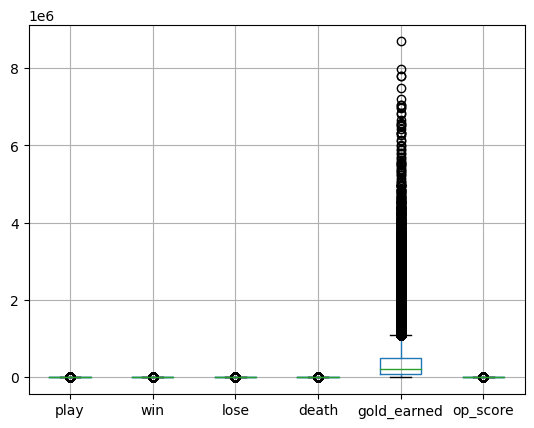

In [1077]:
featureDF.boxplot()

In [965]:
scaler = StandardScaler()

In [1080]:
targetDF.describe().astype('int')

count      85484
mean       59296
std        74697
min          267
25%        14898
50%        33633
75%        74151
max      1255018
Name: game_length_second, dtype: int32

In [967]:
featureDF.isna().sum()

play           0
win            0
lose           0
death          0
gold_earned    0
op_score       0
dtype: int64

In [968]:
targetDF.astype('int').describe().round()

count      85486.0
mean       59330.0
std        75022.0
min          267.0
25%        14899.0
50%        33634.0
75%        74156.0
max      1575661.0
Name: game_length_second, dtype: float64

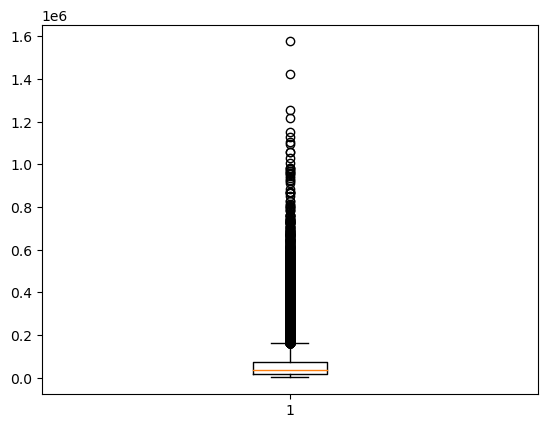

In [969]:
plt.boxplot(targetDF)
plt.show()

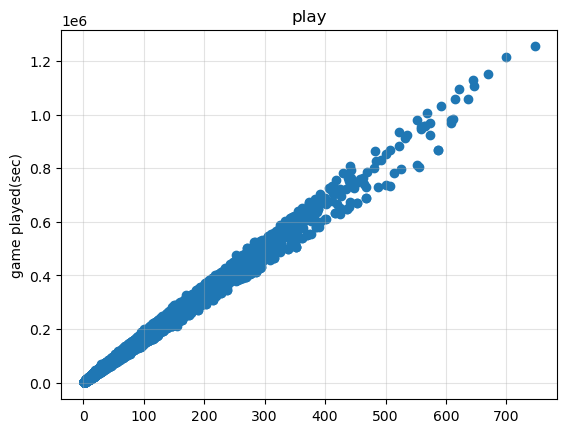

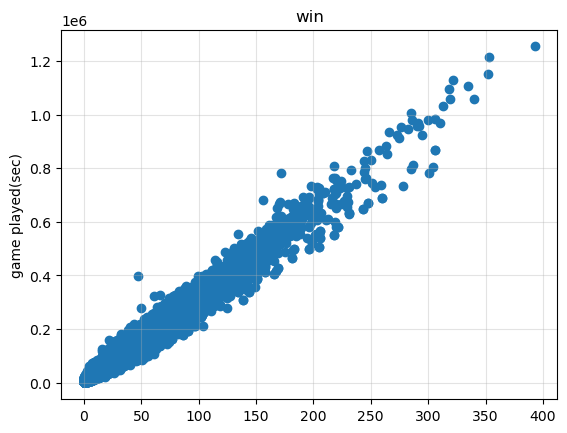

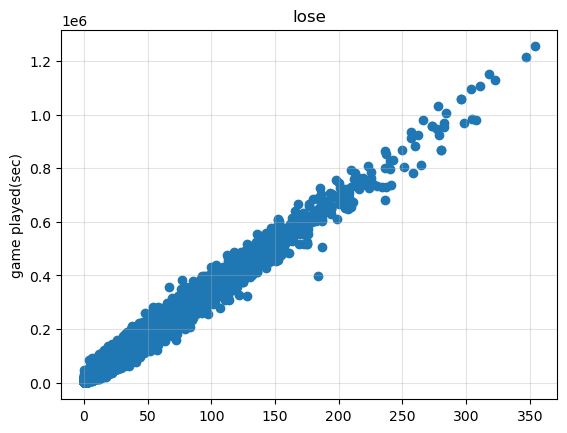

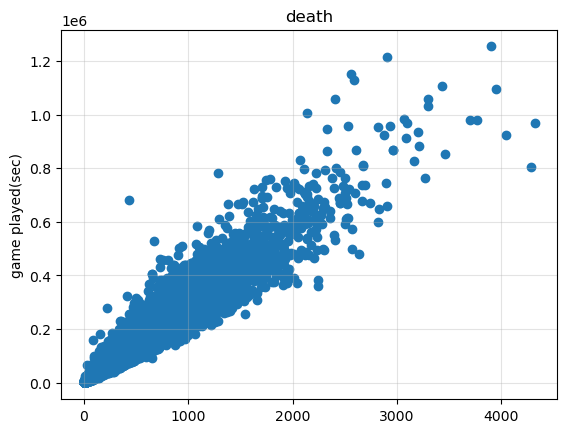

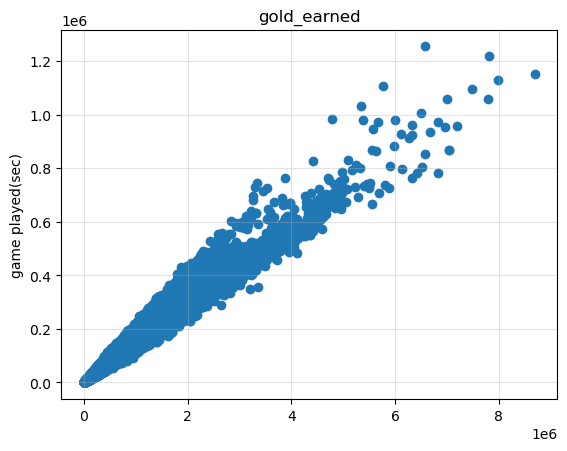

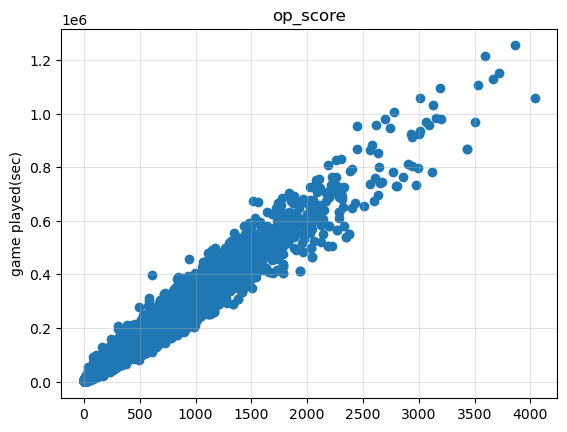

In [1067]:
for col in featureDF.columns:
    plt.scatter(featureDF[col], targetDF)
    plt.title(col)
    plt.ylabel('game played(sec)')
    plt.grid(alpha=0.35)
    plt.show()

In [971]:
targetDF.sort_values(ascending=False).head(2)

9114    1575661.0
376     1425433.0
Name: game_length_second, dtype: float64

In [972]:
mergedNor = mergedNor[mergedNor['game_length_second'] < 1400000]

In [973]:
mergedNor.shape

(85484, 43)

In [974]:
featureDF = mergedNor[['play', 'win', 'lose', 'death', 'gold_earned', 'op_score']]
feature2DF = mergedNor[['death', 'gold_earned', 'op_score']]
targetDF = mergedNor['game_length_second']

In [975]:
scaler.fit(featureDF)
scaled_feature = scaler.transform(featureDF)
scaled_feature

array([[ 1.0975826 ,  1.50297148,  0.6210289 ,  0.10959896,  1.1173108 ,
         1.43806699],
       [ 1.48331574,  1.67329495,  1.23846251,  1.24016614,  1.56312912,
         1.74578591],
       [ 1.21103353,  1.24748629,  1.14347273,  0.96769132,  1.2638766 ,
         1.42542101],
       ...,
       [-0.3772794 , -0.6686527 , -0.04389961, -0.12627477, -0.58606957,
        -0.63587422],
       [ 0.30342614, -0.37058663,  1.04848294, -0.16694265, -0.16376496,
        -0.06680498],
       [-0.5134205 , -0.6686527 , -0.32886897, -0.43535069, -0.57564754,
        -0.62744356]])

In [976]:
feature = torch.as_tensor(featureDF.values, dtype=torch.float32)
target = torch.as_tensor(targetDF, dtype=torch.float32)

In [977]:
feature2 = torch.as_tensor(scaled_feature, dtype=torch.float32)
# target = torch.as_tensor(targetDF, dtype=torch.float32)

In [978]:
# feature

In [979]:
feature.shape, target.shape

(torch.Size([85484, 6]), torch.Size([85484]))

In [980]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [981]:
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

In [982]:
DEVICE

'cpu'

In [983]:
cudaF = feature.to(DEVICE)
cudaT = target.to(DEVICE)

In [984]:
cudaF.is_cuda

False

In [985]:
cudaT.is_cuda

False

In [986]:
class DataSet(Dataset):
    def __init__(self, feature, target):
        super().__init__()
        self.feature = feature
        self.target = target
        
    def __len__(self):
        return feature.shape[0]
    
    def __getitem__(self, idx):
        return self.feature[idx], self.target[idx]
        
    def printShape(self):
        return (self.feature.shape, self.target.shape)

In [987]:
myDataset = DataSet(feature, target)
myDataset2 = DataSet(feature2, target)

In [988]:
feature.shape, target.shape

(torch.Size([85484, 6]), torch.Size([85484]))

In [989]:
myDataset.printShape()

(torch.Size([85484, 6]), torch.Size([85484]))

In [990]:
len(myDataset), len(myDataset2)

(85484, 85484)

In [991]:
torch.manual_seed(40)

In [992]:
trainDS1, validDS1, testDS1 = random_split(myDataset,
                                 [0.7, 0.1, 0.2],
                                 generator=torch.Generator().manual_seed(40))

In [993]:
trainDS2, validDS2, testDS2 = random_split(myDataset2,
                                 [0.7, 0.1, 0.2],
                                 generator=torch.Generator().manual_seed(40))

In [994]:
len(myDataset)

85484

In [995]:
len(trainDS1), len(testDS1)

(59839, 17096)

In [996]:
len(trainDS2), len(testDS2)

(59839, 17096)

In [997]:
BATCH_SIZE = 64

TrainDL1 = DataLoader(trainDS1, batch_size=BATCH_SIZE, drop_last=True
                      # , num_workers=8
                      # , persistent_workers=True
                      )
ValidDL1 =DataLoader(validDS1, batch_size=BATCH_SIZE, drop_last=True
                      # , num_workers=1
                      )
TestDL1 = DataLoader(testDS1, batch_size=BATCH_SIZE, drop_last=True
                     # , num_workers=1
                     )

In [998]:
len(trainDS1), len(myDataset)

(59839, 85484)

In [999]:
# for feature, target in TrainDL1:
#     print(feature)

In [1000]:
TrainDL2 = DataLoader(trainDS2, batch_size=BATCH_SIZE, drop_last=True
                      # , num_workers=1
                      )
ValidDL2 =DataLoader(validDS2, batch_size=BATCH_SIZE, drop_last=True
                      # , num_workers=1
                      )
TestDL2 = DataLoader(testDS2, batch_size=BATCH_SIZE, drop_last=True
                     # , num_workers=1
                     )

In [1001]:
len(TrainDL1), len(TrainDL2), len(myDataset2), len(myDataset)

(934, 934, 85484, 85484)

In [1002]:
# for feature, target in TrainDL1:
#     print(feature)

In [1003]:
class Prototype(nn.Module):
    def __init__(self, features):
        super().__init__()
        
        self.inputLayer = nn.Linear(features, 8)
        # self.hiddenLayer = nn.Sequential()
        self.outputLayer = nn.Linear(8 ,1)
        
    def forward(self, x):
        y = self.inputLayer(x)
        # y = self.hiddenLayer(y)
        y = self.outputLayer(y)
        return y

In [1070]:
summary(model)

Layer (type:depth-idx)                   Param #
Prototype                                --
├─Linear: 1-1                            56
├─Linear: 1-2                            9
Total params: 65
Trainable params: 65
Non-trainable params: 0

In [1004]:
model = Prototype(feature.shape[1]).to(DEVICE)
model2 = Prototype(feature2.shape[1]).to(DEVICE)

In [1005]:
opt = optim.Adam(model.parameters())

In [1006]:
opt2 = optim.Adam(model2.parameters())

In [1007]:
model1_score = {}
model2_score = {}

In [1008]:
len(TrainDL1)

934

In [1009]:
def train_model(model, opt, epochs, T_DataLoader, V_DataLoader, dict):
    model.train()
    train_score_list = []
    valid_score_list = []

    for e in range(1, epochs+1):
        total_train_score = 0
        total_valid_score = 0
        for feature, target in T_DataLoader:
            feature = feature.to(DEVICE)
            target = target.unsqueeze(dim=1).to(DEVICE)
            h = model(feature)
            
            cost = F.mse_loss(h, target).to(DEVICE)
            
            opt.zero_grad()
            cost.backward()
            opt.step()
            
            total_train_score += metrics.r2_score(h, target).item()
        
        model.eval()
        for feature, target in V_DataLoader:
            feature, target = feature.to(DEVICE), target.unsqueeze(dim=1).to(DEVICE)
            
            h = model(feature)
            total_valid_score += metrics.r2_score(h, target).item()
            
        print(f'Epoch: {e:4} -----------')
        print(f'Train score: {total_train_score/len(TrainDL1)}, Validation score: {total_valid_score/len(ValidDL1)}')
        train_score_list.append(total_train_score/len(TrainDL1))
        valid_score_list.append(total_valid_score/len(ValidDL1))
    print(f'Model fitting complete')
    dict['Train score'] = train_score_list
    dict['Validation score'] = valid_score_list

In [1010]:
def test_model(model, DataLoader, dict):
    model.eval()
    test_score_list = []
    MSE_list = []
    MAE_list = []
    MAPE_list = []
    
    for feature, target in DataLoader:
        feature, target = feature.to(DEVICE), target.unsqueeze(dim=1).to(DEVICE)
        pre = model(feature)
        
        r2 = metrics.r2_score(pre, target).item()
        MSE = metrics.mean_squared_error(pre, target).item()
        MAE = metrics.mean_absolute_error(pre, target).item()
        MAPE = metrics.mean_absolute_percentage_error(pre, target).item()
        
        # print(pre - target)
    
        print('r2_score :', r2)
        print('MSE :', MSE)
        print('MAE :', MAE)
        print('MAPE :', MAPE)
        print()
        test_score_list.append(r2)
        MSE_list.append(MSE)
        MAE_list.append(MAE)
        MAPE_list.append(MAPE)
        dict['Test score'] = test_score_list
        dict['MSE'] = MSE_list
        dict['MAE'] = MAE_list
        dict['MAPE'] = MAPE_list

In [1011]:
train_model(model, opt, 100, TrainDL1, ValidDL1, model1_score)

Epoch:    1 -----------
Train score: 0.925608217716217, Validation score: 0.9702073434241733
Epoch:    2 -----------
Train score: 0.9683847851109965, Validation score: 0.9698787425693712
Epoch:    3 -----------
Train score: 0.9682971004883278, Validation score: 0.9695984528477031
Epoch:    4 -----------
Train score: 0.9682835207123317, Validation score: 0.9694968444064147
Epoch:    5 -----------
Train score: 0.9683297949123179, Validation score: 0.9695374123135904
Epoch:    6 -----------
Train score: 0.9684069457860779, Validation score: 0.9696426969721801
Epoch:    7 -----------
Train score: 0.9684962065495567, Validation score: 0.9697651056418741
Epoch:    8 -----------
Train score: 0.9685856809069819, Validation score: 0.9698691677330131
Epoch:    9 -----------
Train score: 0.9686687706114138, Validation score: 0.9699551077713644
Epoch:   10 -----------
Train score: 0.9687501059992666, Validation score: 0.9700419871430648
Epoch:   11 -----------
Train score: 0.9688321768726986, Vali

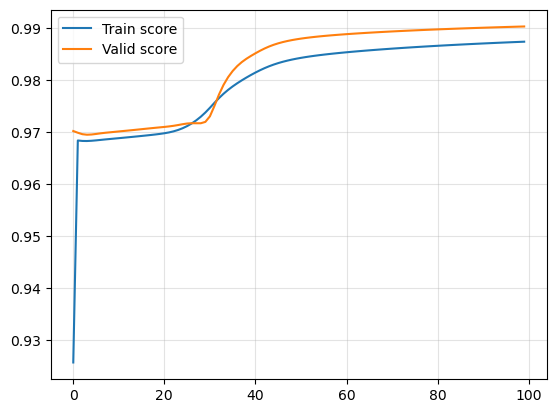

In [1071]:
plt.plot(model1_score['Train score'], label='Train score')
plt.plot(model1_score['Validation score'], label='Valid score')
plt.legend()
plt.grid(alpha=0.35)
plt.show()

In [1013]:
test_model(model, TestDL1, model1_score)

r2_score : 0.9926103353500366
MSE : 30060054.0
MAE : 2952.99853515625
MAPE : 0.07879515737295151

r2_score : 0.9949151277542114
MSE : 29114160.0
MAE : 3122.82421875
MAPE : 0.07226034253835678

r2_score : 0.9942343235015869
MSE : 11843253.0
MAE : 2464.923828125
MAPE : 0.06625916808843613

r2_score : 0.992150604724884
MSE : 48349668.0
MAE : 3870.13525390625
MAPE : 0.07311522960662842

r2_score : 0.9873895049095154
MSE : 47138116.0
MAE : 4024.34912109375
MAPE : 0.0850328579545021

r2_score : 0.993287980556488
MSE : 34618836.0
MAE : 3505.86376953125
MAPE : 0.07652315497398376

r2_score : 0.993600070476532
MSE : 35788704.0
MAE : 3517.903564453125
MAPE : 0.06041191518306732

r2_score : 0.9965158104896545
MSE : 52308720.0
MAE : 3497.019287109375
MAPE : 0.06772316247224808

r2_score : 0.9959468841552734
MSE : 25565604.0
MAE : 3193.94580078125
MAPE : 0.07170342653989792

r2_score : 0.9833729863166809
MSE : 55935648.0
MAE : 4162.61962890625
MAPE : 0.07482673972845078

r2_score : 0.99477082490921

In [1014]:
train_model(model2, opt2, 100, TrainDL2, ValidDL2, model2_score)

Epoch:    1 -----------
Train score: -0.7598386676204281, Validation score: -0.7391226578475838
Epoch:    2 -----------
Train score: -0.7554655461801452, Validation score: -0.7328307270107413
Epoch:    3 -----------
Train score: -0.747699846802738, Validation score: -0.7235563357073561
Epoch:    4 -----------
Train score: -0.7372560324964993, Validation score: -0.7118204186733504
Epoch:    5 -----------
Train score: -0.7245234969596536, Validation score: -0.6979096778353354
Epoch:    6 -----------
Train score: -0.7097224217921304, Validation score: -0.6819931627216196
Epoch:    7 -----------
Train score: -0.6929895597045376, Validation score: -0.6641834983252045
Epoch:    8 -----------
Train score: -0.6744225032834986, Validation score: -0.6445675218911996
Epoch:    9 -----------
Train score: -0.6541015297748802, Validation score: -0.6232213821626247
Epoch:   10 -----------
Train score: -0.6321002133908568, Validation score: -0.6002175556985956
Epoch:   11 -----------
Train score: -0.6

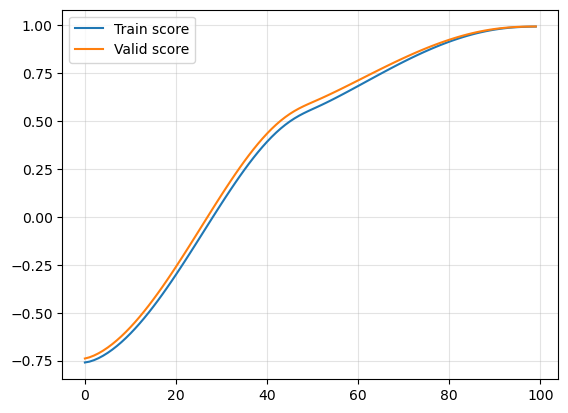

In [1072]:
plt.plot(model2_score['Train score'], label='Train score')
plt.plot(model2_score['Validation score'], label='Valid score')
plt.legend()
plt.grid(alpha=0.35)
plt.show()

In [1016]:
test_model(model2, TestDL2, model2_score)

r2_score : 0.9958933591842651
MSE : 16705257.0
MAE : 2285.072509765625
MAPE : 0.0740024521946907

r2_score : 0.9966158270835876
MSE : 19376430.0
MAE : 2437.3515625
MAPE : 0.060835354030132294

r2_score : 0.9966582655906677
MSE : 6864255.5
MAE : 2043.862548828125
MAPE : 0.06497548520565033

r2_score : 0.9947521090507507
MSE : 32325294.0
MAE : 3042.035888671875
MAPE : 0.05594736337661743

r2_score : 0.9938346743583679
MSE : 23046050.0
MAE : 3061.686279296875
MAPE : 0.07358785718679428

r2_score : 0.9963850378990173
MSE : 18645216.0
MAE : 2522.919921875
MAPE : 0.061956245452165604

r2_score : 0.9970813393592834
MSE : 16321448.0
MAE : 2470.733154296875
MAPE : 0.05710326135158539

r2_score : 0.9990804195404053
MSE : 13805625.0
MAE : 2305.011474609375
MAPE : 0.06654418259859085

r2_score : 0.9987626075744629
MSE : 7805053.5
MAE : 2047.9774169921875
MAPE : 0.06378871202468872

r2_score : 0.9908339977264404
MSE : 30835752.0
MAE : 2912.623779296875
MAPE : 0.06354577839374542

r2_score : 0.99747

In [1017]:
len(TestDL1)

267

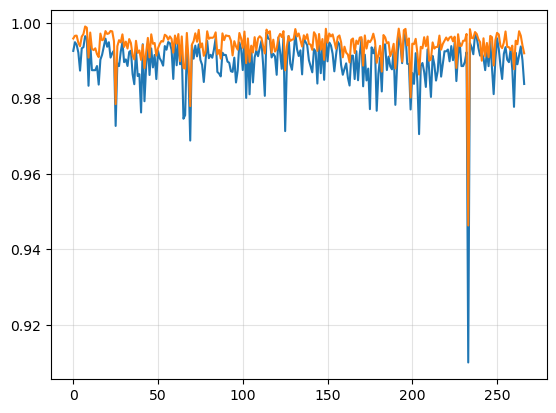

In [1018]:
plt.plot(model1_score['Test score'], label='model1')
plt.plot(model2_score['Test score'], label='model2')
plt.grid(alpha=0.35)
plt.show()

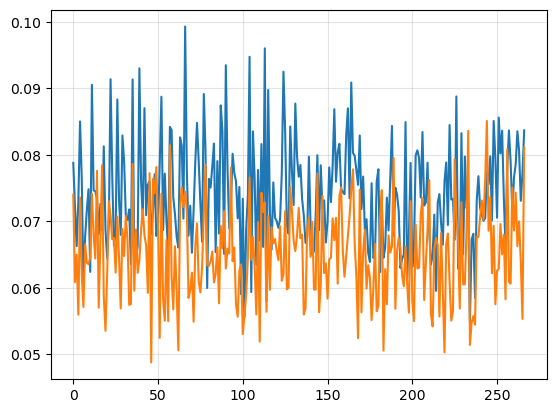

In [1019]:
plt.plot(model1_score['MAPE'], label='model1')
plt.plot(model2_score['MAPE'], label='model2')
plt.grid(alpha=0.35)
plt.show()

In [1020]:
model1_score['MSE']

[30060054.0,
 29114160.0,
 11843253.0,
 48349668.0,
 47138116.0,
 34618836.0,
 35788704.0,
 52308720.0,
 25565604.0,
 55935648.0,
 19402662.0,
 50236360.0,
 23085014.0,
 29380184.0,
 33202376.0,
 66384976.0,
 65601272.0,
 34001296.0,
 13740283.0,
 42381136.0,
 21565088.0,
 15139094.0,
 49831156.0,
 34513464.0,
 24716496.0,
 92422792.0,
 56747240.0,
 57261996.0,
 42030728.0,
 61415844.0,
 26663460.0,
 75626536.0,
 24928748.0,
 22656730.0,
 31951104.0,
 27139292.0,
 90195944.0,
 26551516.0,
 44215556.0,
 30178878.0,
 120864576.0,
 14048034.0,
 105478208.0,
 48725656.0,
 11512046.0,
 139287984.0,
 26507234.0,
 67101740.0,
 60837060.0,
 96585920.0,
 23853162.0,
 61698348.0,
 110356304.0,
 52078300.0,
 32817074.0,
 36732716.0,
 18929672.0,
 33011122.0,
 63045520.0,
 47444476.0,
 42678484.0,
 35513708.0,
 32601644.0,
 45201900.0,
 23240340.0,
 71163728.0,
 64565312.0,
 35446604.0,
 32107416.0,
 495814272.0,
 73579008.0,
 36503512.0,
 49893036.0,
 64700236.0,
 59845384.0,
 20709280.0,
 517799

In [1021]:
model2_score['MSE']

[16705257.0,
 19376430.0,
 6864255.5,
 32325294.0,
 23046050.0,
 18645216.0,
 16321448.0,
 13805625.0,
 7805053.5,
 30835752.0,
 9383340.0,
 27527376.0,
 13241895.0,
 15747798.0,
 24052236.0,
 36773588.0,
 18942702.0,
 18452796.0,
 9450152.0,
 21954200.0,
 9917869.0,
 8197293.5,
 11470030.0,
 9620460.0,
 16138530.0,
 72819904.0,
 32805178.0,
 22791196.0,
 28369614.0,
 36286248.0,
 16292437.0,
 38635656.0,
 14813138.0,
 12568117.0,
 23106496.0,
 17267432.0,
 53711796.0,
 17642426.0,
 24936108.0,
 16209728.0,
 49823920.0,
 14457874.0,
 60741924.0,
 33133630.0,
 8348390.0,
 92228696.0,
 11821630.0,
 31484100.0,
 38044672.0,
 56250144.0,
 21541972.0,
 36598308.0,
 51941704.0,
 22670608.0,
 16710044.0,
 17861260.0,
 16662405.0,
 21923350.0,
 37346784.0,
 25146120.0,
 32758324.0,
 17414440.0,
 21519564.0,
 41865332.0,
 10919408.0,
 33373608.0,
 31966652.0,
 15386041.0,
 22429984.0,
 350355616.0,
 71555912.0,
 18620678.0,
 22730952.0,
 36408204.0,
 19394932.0,
 13757373.0,
 25229274.0,
 48995

In [1022]:
torch.__version__

'2.2.1'

In [1023]:
torch.cuda.device_count()

1

In [1024]:
torch.cuda.current_device()

0

In [1025]:
mergedNor.columns

Index(['id', 'play', 'win', 'lose', 'kill', 'death', 'assist', 'gold_earned',
       'minion_kill', 'turret_kill', 'neutral_minion_kill', 'damage_dealt',
       'damage_taken', 'physical_damage_dealt', 'magic_damage_dealt',
       'most_kill', 'max_kill', 'max_death', 'double_kill', 'triple_kill',
       'quadra_kill', 'penta_kill', 'game_length_second', 'inhibitor_kills',
       'sight_wards_bought_in_game', 'vision_wards_bought_in_game',
       'vision_score', 'wards_placed', 'wards_killed', 'heal',
       'time_ccing_others', 'op_score', 'is_max_in_team_op_score',
       'physical_damage_taken', 'damage_dealt_to_champions',
       'physical_damage_dealt_to_champions', 'magic_damage_dealt_to_champions',
       'damage_dealt_to_objectives', 'damage_dealt_to_turrets',
       'damage_self_mitigated', 'max_largest_multi_kill',
       'max_largest_critical_strike', 'max_largest_killing_spree'],
      dtype='object')

In [1026]:
feature3DF = mergedNor[['kill', 'death', 'assist']]

In [1081]:
mergedNor[['kill', 'death', 'assist']]

,kill,death,assist
0,451.0,219.0,586.0
1,681.0,497.0,657.0
2,580.0,430.0,655.0
3,2189.0,651.0,1359.0
4,581.0,260.0,419.0
...,...,...,...
85481,104.0,300.0,120.0
85482,34.0,120.0,110.0
85483,27.0,161.0,61.0
85484,94.0,151.0,192.0


In [1027]:
feature3DF.isna().sum()

kill      0
death     0
assist    0
dtype: int64

In [1028]:
type(feature3DF)

pandas.core.frame.DataFrame

In [1029]:
feature3 = torch.as_tensor(feature3DF.values, dtype=torch.float32)
target = torch.as_tensor(targetDF, dtype=torch.float32)

In [1030]:
scaler2 = StandardScaler()
scaler2.fit(feature3)
scaled_feature2 = scaler2.transform(feature3)

In [1031]:
scaled_feature2.shape, scaled_feature2.shape

((85484, 3), (85484, 3))

In [1032]:
scaled_feature2 = torch.as_tensor(scaled_feature2, dtype=torch.float32)

In [1033]:
model3 = Prototype(scaled_feature2.shape[1]).to(DEVICE)

In [1034]:
opt3 = optim.Adam(model3.parameters())

In [1035]:
myDataset3 = DataSet(scaled_feature2, target)

In [1036]:
myDataset3.feature.shape, myDataset3.target.shape

(torch.Size([85484, 3]), torch.Size([85484]))

In [1037]:
len(myDataset3)

85484

In [1038]:
len(myDataset3)

85484

In [1039]:
myDataset3.feature.shape[0]

85484

In [1040]:
myDataset3.printShape()

(torch.Size([85484, 3]), torch.Size([85484]))

In [1041]:
trainDS3, validDS3, testDS3 = random_split(myDataset3, [0.7, 0.1, 0.2], generator=torch.Generator().manual_seed(40))

In [1042]:
len(trainDS3)

59839

In [1043]:
myDataset3.printShape()

(torch.Size([85484, 3]), torch.Size([85484]))

In [1044]:
len(myDataset2)

85484

In [1045]:
len(myDataset3)

85484

In [1046]:
myDataset.feature

tensor([[8.3000e+01, 5.4000e+01, 2.9000e+01, 2.1900e+02, 9.5098e+05, 5.2600e+02],
        [1.0000e+02, 5.8000e+01, 4.2000e+01, 4.9700e+02, 1.1734e+06, 5.9900e+02],
        [8.8000e+01, 4.8000e+01, 4.0000e+01, 4.3000e+02, 1.0241e+06, 5.2300e+02],
        ...,
        [1.8000e+01, 3.0000e+00, 1.5000e+01, 1.6100e+02, 1.0109e+05, 3.4000e+01],
        [4.8000e+01, 1.0000e+01, 3.8000e+01, 1.5100e+02, 3.1179e+05, 1.6900e+02],
        [1.2000e+01, 3.0000e+00, 9.0000e+00, 8.5000e+01, 1.0629e+05, 3.6000e+01]])

In [1047]:
myDataset3.feature

tensor([[ 0.8575,  0.1096,  0.8778],
        [ 1.6771,  1.2402,  1.0713],
        [ 1.3172,  0.9677,  1.0658],
        ...,
        [-0.6535, -0.1263, -0.5530],
        [-0.4147, -0.1669, -0.1960],
        [-0.5893, -0.4354, -0.6129]])

In [1048]:
len(trainDS3), len(validDS3), len(testDS3)

(59839, 8549, 17096)

In [1049]:
len(trainDS1), len(validDS1), len(testDS1)

(59839, 8549, 17096)

In [1050]:
trainDS3[0]

(tensor([1.0891, 0.3414, 0.1583]), tensor(88314.))

In [1051]:
TrainDL3 = DataLoader(trainDS3, batch_size=BATCH_SIZE, drop_last=True)
ValidDL3 = DataLoader(validDS3, batch_size=BATCH_SIZE, drop_last=True)
TestDL3 = DataLoader(testDS3, batch_size=BATCH_SIZE, drop_last=True)

In [1052]:
len(TrainDL3)

934

In [1053]:
for feature, target in TrainDL3:
    print(feature.shape, target.shape)

torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
torch.Size([64, 3]) torch.Size([64])
t

In [1054]:
model3_score = {}

In [1055]:
train_model(model3, opt3, 100, TrainDL3, ValidDL3, model3_score)

Epoch:    1 -----------
Train score: -0.7602181395065095, Validation score: -0.7402284181207642
Epoch:    2 -----------
Train score: -0.7577491633641898, Validation score: -0.7366764151064077
Epoch:    3 -----------
Train score: -0.7532773502888975, Validation score: -0.7314114785732183
Epoch:    4 -----------
Train score: -0.747237205377738, Validation score: -0.7247213815387926
Epoch:    5 -----------
Train score: -0.7398430708899488, Validation score: -0.7167578568135885
Epoch:    6 -----------
Train score: -0.7312104464598335, Validation score: -0.7076052230103571
Epoch:    7 -----------
Train score: -0.7214059476168304, Validation score: -0.6973146926191517
Epoch:    8 -----------
Train score: -0.7104723764946425, Validation score: -0.6859216967919716
Epoch:    9 -----------
Train score: -0.6984415789487786, Validation score: -0.6734545840356583
Epoch:   10 -----------
Train score: -0.6853402342479795, Validation score: -0.6599382753659012
Epoch:   11 -----------
Train score: -0.6

In [1056]:
# torch.save(model, 'model1.pth')
# torch.save(model2, 'model2.pth')
# torch.save(model3, 'model3.pth')

In [1057]:
test_model(model3, TestDL3, model3_score)

r2_score : 0.9785048365592957
MSE : 87439328.0
MAE : 6027.27880859375
MAPE : 0.2877240777015686

r2_score : 0.977764368057251
MSE : 127312952.0
MAE : 6664.41357421875
MAPE : 0.2985190749168396

r2_score : 0.9726239442825317
MSE : 56232960.0
MAE : 5621.6396484375
MAPE : 0.20820851624011993

r2_score : 0.9645064473152161
MSE : 218628448.0
MAE : 8130.64990234375
MAPE : 0.19642457365989685

r2_score : 0.9642825126647949
MSE : 133512384.0
MAE : 7166.6376953125
MAPE : 0.20625683665275574

r2_score : 0.984383761882782
MSE : 80544576.0
MAE : 6043.7900390625
MAPE : 0.2046993374824524

r2_score : 0.9755690097808838
MSE : 136619104.0
MAE : 7237.99560546875
MAPE : 0.22588494420051575

r2_score : 0.9912217259407043
MSE : 131788576.0
MAE : 6510.6044921875
MAPE : 0.21480289101600647

r2_score : 0.989740788936615
MSE : 64711240.0
MAE : 5803.546875
MAPE : 0.20104512572288513

r2_score : 0.9622272849082947
MSE : 127072704.0
MAE : 7330.5703125
MAPE : 0.23428910970687866

r2_score : 0.9809495210647583
MSE

In [1058]:
model1_score.keys()

dict_keys(['Train score', 'Validation score', 'Test score', 'MSE', 'MAE', 'MAPE'])

In [1063]:
for key in list(model1_score.keys())[2:]:
    for idx, modelScore in enumerate([model1_score, model2_score, model3_score]):
        print(f'Model {idx}({key}) :: ', sum(modelScore[key])/len(modelScore[key]))
    print()

Model 0(Test score) ::  0.9895534513148476
Model 1(Test score) ::  0.9942149894960811
Model 2(Test score) ::  0.9693055364969518

Model 0(MSE) ::  55965524.05617978
Model 1(MSE) ::  31939030.554307114
Model 2(MSE) ::  159447815.89513108

Model 0(MAE) ::  3732.9071378672165
Model 1(MAE) ::  2855.8515538133483
Model 2(MAE) ::  7191.730154201779

Model 0(MAPE) ::  0.07415514126810688
Model 1(MAPE) ::  0.06528607698694597
Model 2(MAPE) ::  0.22052193580941762


In [1064]:
for key in list(model1_score.keys())[2:]:
    for idx, modelScore in enumerate([model1_score, model2_score]):
        print(f'Model {idx}({key}) :: ', sum(modelScore[key])/len(modelScore[key]))
    print()

Model 0(Test score) ::  0.9895534513148476
Model 1(Test score) ::  0.9942149894960811

Model 0(MSE) ::  55965524.05617978
Model 1(MSE) ::  31939030.554307114

Model 0(MAE) ::  3732.9071378672165
Model 1(MAE) ::  2855.8515538133483

Model 0(MAPE) ::  0.07415514126810688
Model 1(MAPE) ::  0.06528607698694597


In [1065]:
for key in list(model1_score.keys())[2:]:
    for idx, modelScore in enumerate([model1_score]):
        print(f'Model {idx}({key}) :: ', sum(modelScore[key])/len(modelScore[key]))
    print()

Model 0(Test score) ::  0.9895534513148476

Model 0(MSE) ::  55965524.05617978

Model 0(MAE) ::  3732.9071378672165

Model 0(MAPE) ::  0.07415514126810688


In [1073]:
print(max(model1_score['Validation score']))

0.9903545558900761


In [1074]:
print(max(model2_score['Validation score']))

0.994530481503422


In [1075]:
print(max(model3_score['Validation score']))

0.9701583775362574


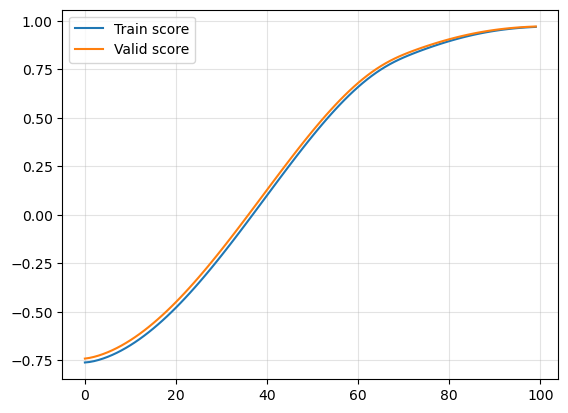

In [1076]:
plt.plot(model3_score['Train score'], label='Train score')
plt.plot(model3_score['Validation score'], label='Valid score')
plt.legend()
plt.grid(alpha=0.35)
plt.show()

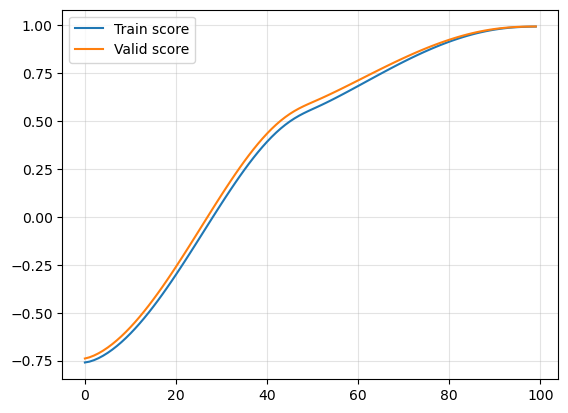

In [1078]:
plt.plot(model2_score['Train score'], label='Train score')
plt.plot(model2_score['Validation score'], label='Valid score')
plt.legend()
plt.grid(alpha=0.35)
plt.show()